# PREDIÇÃO DOS CANDIDATOS QUE FIZERAM O ENEM 2016 COMO TREINEIROS

## Importação das bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (f1_score, confusion_matrix, roc_curve, 
                             roc_auc_score, classification_report)
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.rc("figure", figsize=(10, 6))
sns.set(style="dark", palette="Accent")

## Exploração dos dados

In [5]:
df_train = pd.read_csv("train.csv")
df_test  = pd.read_csv("test.csv").drop(columns="NU_INSCRICAO")

In [6]:
df_train.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,...,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,...,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,...,NaN,A,A,A,A,A,A,A,A,A


In [7]:
df_test.head()

,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,...,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q006,Q024,Q025,Q026,Q027,Q047
0,43,RS,19,F,1,1,1,3,1,NaN,...,NaN,NaN,E,E,H,B,B,C,D,A
1,15,PA,24,M,3,2,1,4,1,NaN,...,NaN,NaN,B,C,B,A,A,C,D,A
2,29,BA,16,F,2,1,3,0,1,NaN,...,NaN,NaN,E,F,G,B,B,A,NaN,D
3,41,PR,17,F,1,1,2,0,2,1.0,...,40.0,480.0,E,E,E,C,B,B,C,A
4,53,DF,19,F,1,1,1,1,1,NaN,...,80.0,720.0,E,E,E,B,B,B,D,A


## Seleção Features de Treino.

In [8]:
features = list(df_test.columns)
features.append("IN_TREINEIRO")
df_train = df_train[features]
df_train.columns

Index(['CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
       'TP_ESCOLA', 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC', 'IN_BAIXA_VISAO',
       'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA', 'IN_DISCALCULIA',
       'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO', 'TP_PRESENCA_CN',
       'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'NU_NOTA_CN',
       'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'TP_STATUS_REDACAO',
       'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3', 'NU_NOTA_COMP4',
       'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002', 'Q006', 'Q024',
       'Q025', 'Q026', 'Q027', 'Q047', 'IN_TREINEIRO'],
      dtype='object')

## Análise dos Dados
### Treino

In [8]:
df_train.describe()

,CO_UF_RESIDENCIA,NU_IDADE,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,...,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,IN_TREINEIRO
count,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,13730.000000,4282.000000,4282.000000,13730.000000,...,10133.000000,13730.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,10133.000000,13730.000000
mean,30.736708,21.593809,2.185652,1.048871,1.782666,2.146176,1.353532,1.178888,2.259692,0.001238,...,516.472841,0.593664,1.101747,119.811704,111.915918,106.824238,113.123951,77.372446,529.048258,0.129862
std,9.862405,7.043654,1.007285,0.258895,0.880734,3.217328,0.558472,0.565490,0.698586,0.035167,...,68.688190,0.491167,0.700100,29.846017,33.737588,34.341349,33.480033,43.067140,154.294758,0.336163
min,11.000000,13.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,17.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,...,468.100000,0.000000,1.000000,120.000000,100.000000,80.000000,100.000000,40.000000,440.000000,0.000000
50%,31.000000,19.000000,3.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,...,520.900000,1.000000,1.000000,120.000000,120.000000,120.000000,120.000000,80.000000,540.000000,0.000000
75%,35.000000,23.000000,3.000000,1.000000,2.000000,3.000000,2.000000,1.000000,2.000000,0.000000,...,564.900000,1.000000,1.000000,140.000000,120.000000,120.000000,120.000000,100.000000,600.000000,0.000000
max,53.000000,67.000000,5.000000,4.000000,4.000000,10.000000,4.000000,3.000000,4.000000,1.000000,...,763.600000,1.000000,9.000000,200.000000,200.000000,200.000000,200.000000,200.000000,1000.000000,1.000000


### Range dos valores

In [10]:
print("Faixa de Valores - Dados de Treino\n")
print(f"Valor mínimo: {df_train.describe().loc['min'].min()}")
print(f"Valor máximo: {df_train.describe().loc['max'].max()}")

Faixa de Valores - Dados de Treino

Valor mínimo: 0.0
Valor máximo: 1000.0


### Teste

In [11]:
df_test.describe()

,CO_UF_RESIDENCIA,NU_IDADE,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_DEPENDENCIA_ADM_ESC,IN_BAIXA_VISAO,...,NU_NOTA_CH,NU_NOTA_LC,TP_LINGUA,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO
count,4570.000000,4570.000000,4570.000000,4570.000000,4570.000000,4570.000000,4570.000000,1426.000000,1426.000000,4570.000000,...,3458.000000,3400.000000,4570.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000
mean,31.029322,21.545295,2.176586,1.046827,1.767615,2.172867,1.357987,1.166199,2.286115,0.002188,...,528.615818,516.102471,0.609190,1.090000,118.988824,111.599118,106.130882,112.402941,76.376471,525.498235
std,9.901375,6.790798,0.996656,0.245769,0.871374,3.250585,0.567280,0.546511,0.721239,0.046732,...,73.278207,69.141624,0.487985,0.668384,29.067885,33.150519,33.553963,32.801291,43.295267,151.640060
min,11.000000,14.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,17.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000,...,479.525000,469.100000,0.000000,1.000000,120.000000,100.000000,80.000000,100.000000,40.000000,440.000000
50%,31.000000,19.000000,3.000000,1.000000,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,...,531.200000,521.800000,1.000000,1.000000,120.000000,120.000000,100.000000,120.000000,80.000000,520.000000
75%,35.000000,23.000000,3.000000,1.000000,2.000000,3.000000,2.000000,1.000000,2.000000,0.000000,...,580.975000,564.825000,1.000000,1.000000,140.000000,120.000000,120.000000,120.000000,100.000000,600.000000
max,53.000000,63.000000,5.000000,4.000000,4.000000,10.000000,4.000000,3.000000,4.000000,1.000000,...,750.700000,730.600000,1.000000,9.000000,200.000000,200.000000,200.000000,200.000000,200.000000,960.000000


### Range dos valores

In [12]:
print("Faixa de Valores - Dados de Teste\n")
print(f"Valor mínimo: {df_test.describe().loc['min'].min()}")
print(f"Valor máximo: {df_test.describe().loc['max'].max()}")

Faixa de Valores - Dados de Teste

Valor mínimo: 0.0
Valor máximo: 960.0


## Análise Exploratória dos Dados

In [15]:
df_train.isna().sum()

CO_UF_RESIDENCIA             0
SG_UF_RESIDENCIA             0
NU_IDADE                     0
TP_SEXO                      0
TP_COR_RACA                  0
TP_NACIONALIDADE             0
TP_ST_CONCLUSAO              0
TP_ANO_CONCLUIU              0
TP_ESCOLA                    0
TP_ENSINO                 9448
TP_DEPENDENCIA_ADM_ESC    9448
IN_BAIXA_VISAO               0
IN_CEGUEIRA                  0
IN_SURDEZ                    0
IN_DISLEXIA                  0
IN_DISCALCULIA               0
IN_SABATISTA                 0
IN_GESTANTE                  0
IN_IDOSO                     0
TP_PRESENCA_CN               0
TP_PRESENCA_CH               0
TP_PRESENCA_LC               0
TP_PRESENCA_MT               0
NU_NOTA_CN                3389
NU_NOTA_CH                3389
NU_NOTA_LC                3597
TP_LINGUA                    0
TP_STATUS_REDACAO         3597
NU_NOTA_COMP1             3597
NU_NOTA_COMP2             3597
NU_NOTA_COMP3             3597
NU_NOTA_COMP4             3597
NU_NOTA_

In [16]:
df_test.isna().sum()

CO_UF_RESIDENCIA             0
SG_UF_RESIDENCIA             0
NU_IDADE                     0
TP_SEXO                      0
TP_COR_RACA                  0
TP_NACIONALIDADE             0
TP_ST_CONCLUSAO              0
TP_ANO_CONCLUIU              0
TP_ESCOLA                    0
TP_ENSINO                 3144
TP_DEPENDENCIA_ADM_ESC    3144
IN_BAIXA_VISAO               0
IN_CEGUEIRA                  0
IN_SURDEZ                    0
IN_DISLEXIA                  0
IN_DISCALCULIA               0
IN_SABATISTA                 0
IN_GESTANTE                  0
IN_IDOSO                     0
TP_PRESENCA_CN               0
TP_PRESENCA_CH               0
TP_PRESENCA_LC               0
TP_PRESENCA_MT               0
NU_NOTA_CN                1112
NU_NOTA_CH                1112
NU_NOTA_LC                1170
TP_LINGUA                    0
TP_STATUS_REDACAO         1170
NU_NOTA_COMP1             1170
NU_NOTA_COMP2             1170
NU_NOTA_COMP3             1170
NU_NOTA_COMP4             1170
NU_NOTA_

### Conclusão:
- Não há valores faltantes na nossa variável alvo IN_TRENEIRO;
- As features com dados faltantes são exatamente as mesmas nas duas bases de dados e na mesma proporção.

Vamos substituir os dados faltantes por (-1). Dessa forma, preservamos o vínculo existente entre algumas das variáveis e não confundimos o modelo imputando valores que possivelmente estejam dentro do range dessas variáveis.

In [17]:
df_test.drop(columns=["TP_DEPENDENCIA_ADM_ESC", "TP_ENSINO", "Q027"], inplace=True)
df_train.drop(columns=["TP_DEPENDENCIA_ADM_ESC", "TP_ENSINO", "Q027"], inplace=True)

In [18]:
df_test.fillna(-1, inplace=True)
df_train.fillna(-1, inplace=True)

In [19]:
print(f"Valores vazios ns dados de Teste: {df_test.isna().sum().sum()}")
print(f"Valores vazios ns dados de Treino: {df_train.isna().sum().sum()}")

Valores vazios ns dados de Teste: 0
Valores vazios ns dados de Treino: 0


## Balanceando as Classes

In [25]:
x_train = df_train.drop(columns="IN_TREINEIRO", errors="ignore")
y_train = df_train["IN_TREINEIRO"]
x_test = df_test.copy()

In [26]:
# Separando as variáveis em categóricas e numéricas.
siglas_categoricas = ["CO", "SG", "TP", "IN", "Q0"]
cat_features = [i for i in x_train.columns if i[:2] in siglas_categoricas]
num_features = x_train.columns.drop(cat_features)

Temos presente em nosso conjunto de dados variáveis do tipo qualitativa (**variáveis categóricas**), precisamos submetê-las a um processo de codificacão.

A técnica de codificação utilizaremos aqui é o **One-Hot-Encoder**.
### Encodando com o One-Hot-Enconder.

In [27]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore', dtype=np.int)

ohe.fit(x_train[cat_features])

x_train_encoded = ohe.transform(x_train[cat_features])
x_test_encoded  = ohe.transform(df_test[cat_features])

x_train_encoded = pd.DataFrame(x_train_encoded, columns=ohe.get_feature_names(cat_features))
x_train_encoded = pd.concat([x_train_encoded, x_train[num_features].reset_index(drop=True)], axis=1)

x_test_encoded = pd.DataFrame(x_test_encoded, columns=ohe.get_feature_names(cat_features))
x_test_encoded = pd.concat([x_test_encoded, x_test[num_features].reset_index(drop=True)], axis=1)

### Aplicando o SMOTE para balancear nossas classes.

In [28]:
smote = SMOTE(sampling_strategy="minority")

x_train_balanceado, y_train = smote.fit_resample(x_train_encoded, y_train)

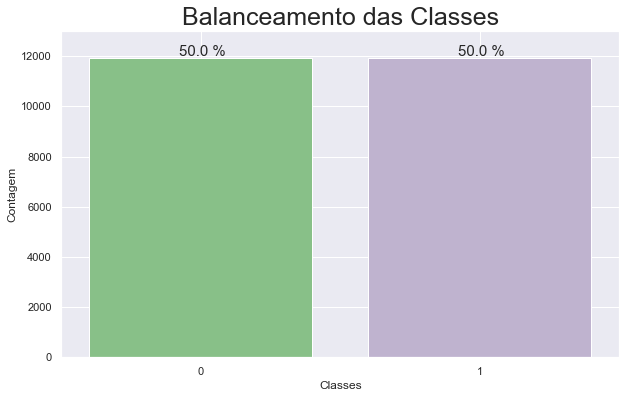

In [29]:
plota_classes(y_train)

Agora que temos nossas classes balanceadas, podemos criar e treinar nosso modelo para predizer nossas classes.
## Separando os Dados em Treino e Teste

In [30]:
treino_x, teste_x, treino_y, teste_y = train_test_split(x_train_balanceado, y_train, 
                                                       test_size=0.3, random_state=42) 

print(f"Temos {treino_x.shape[0]} dados para treino e {teste_x.shape[0]} para teste.")

Temos 16725 dados para treino e 7169 para teste.


## Seleção de Features com Random Forest
Após todas as etapas de modelagem e reamostragem de dados que fizemos até aqui, nosso Data Frame de treino ficou assim:

In [31]:
x_train_balanceado.head()

,CO_UF_RESIDENCIA_11,CO_UF_RESIDENCIA_12,CO_UF_RESIDENCIA_13,CO_UF_RESIDENCIA_14,CO_UF_RESIDENCIA_15,CO_UF_RESIDENCIA_16,CO_UF_RESIDENCIA_17,CO_UF_RESIDENCIA_21,CO_UF_RESIDENCIA_22,CO_UF_RESIDENCIA_23,...,NU_IDADE,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO
0,0,0,0,0,0,0,0,0,0,0,...,24,436.3,495.4,581.2,120.0,120.0,120.0,80.0,80.0,520.0
1,0,0,0,0,0,0,0,0,0,1,...,17,474.5,544.1,599.0,140.0,120.0,120.0,120.0,80.0,580.0
2,0,0,0,0,0,0,0,0,0,1,...,21,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,0,0,0,0,0,0,0,0,0,0,...,25,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,0,0,1,0,0,0,0,0,0,0,...,28,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [27]:
print(f"Temos {x_train_balanceado.shape[0]} registros e {x_train_balanceado.shape[1]} colunas.")

Temos 23894 registros e 183 colunas.


In [32]:
# Selecao de Features Utilizando Random Forest.
clf_rf = RandomForestClassifier(random_state=1)
clf_rf.fit(treino_x, treino_y)

selection_features = pd.DataFrame()
selection_features["features"] = treino_x.columns
selection_features["importancia"] = clf_rf.feature_importances_

selection_features = selection_features[selection_features["importancia"] > np.mean(selection_features["importancia"])].sort_values("importancia", ascending=False)
selection_features.reset_index(drop=True, inplace=True)

treino_x_importance = treino_x[selection_features["features"]]
teste_x_importance = teste_x[selection_features["features"]]
selection_features

,features,importancia
0,TP_ST_CONCLUSAO_3,0.213083
1,NU_IDADE,0.199957
2,TP_ANO_CONCLUIU_0,0.081902
3,TP_ESCOLA_1,0.080091
4,TP_ST_CONCLUSAO_1,0.073851
5,TP_ST_CONCLUSAO_2,0.059187
6,TP_ESCOLA_2,0.054376
7,Q026_B,0.034353
8,Q026_C,0.026549
9,Q026_A,0.016206


In [33]:
features_selected = selection_features["features"].values
features_selected

array(['TP_ST_CONCLUSAO_3', 'NU_IDADE', 'TP_ANO_CONCLUIU_0',
       'TP_ESCOLA_1', 'TP_ST_CONCLUSAO_1', 'TP_ST_CONCLUSAO_2',
       'TP_ESCOLA_2', 'Q026_B', 'Q026_C', 'Q026_A', 'TP_ANO_CONCLUIU_1',
       'Q001_B', 'TP_ST_CONCLUSAO_4', 'TP_ANO_CONCLUIU_2'], dtype=object)

## Treinado e Avaliando Modelos

In [34]:
def plota_roc_curve(fpr, tpr, predicoes, label):
    plt.title("ROC Curve", fontsize=20)
    plt.ylabel("TPR or Sensitivity", fontsize=20)
    plt.xlabel("FPR or (1 - specificity)", fontsize=20)
    plt.plot(fpr, tpr, label=f"{label}")
    plt.plot([0, 1], [0, 1], ls="--", color="r", label="Sorte")
    plt.legend(fontsize=16)
    plt.grid(True)
    plt.show()
    
    print(classification_report(teste_y, predicoes))
    print(f"AUC: {roc_auc_score(teste_y, predicoes)}")

In [35]:
# Definindo funação que plota a matriz de confusão.
def plot_matriz_confusao(teste_y, predict, title):
    plt.figure(figsize=(6, 6))
    matriz_confusao = confusion_matrix(teste_y, predict)
    sns.heatmap(matriz_confusao, cmap="YlGnBu", annot=True, fmt="d", cbar=False)
    plt.title(f"Matriz de Confusão - {title}", fontsize=20, pad=15)
    plt.xlabel("Previsto", fontsize=20, labelpad=15)
    plt.ylabel("Real", fontsize=20, labelpad=15)
    plt.xticks(ticks=[0.5, 1.5] ,labels=["Não-treineiro", "Treineiro"], fontsize=16)
    plt.yticks(ticks=[0.25 , 1.25] ,labels=["Não-treineiro", "Treineiro"], fontsize=16)
    plt.show()

### Random Forest

In [36]:
features_selected[:-1]

array(['TP_ST_CONCLUSAO_3', 'NU_IDADE', 'TP_ANO_CONCLUIU_0',
       'TP_ESCOLA_1', 'TP_ST_CONCLUSAO_1', 'TP_ST_CONCLUSAO_2',
       'TP_ESCOLA_2', 'Q026_B', 'Q026_C', 'Q026_A', 'TP_ANO_CONCLUIU_1',
       'Q001_B', 'TP_ST_CONCLUSAO_4'], dtype=object)

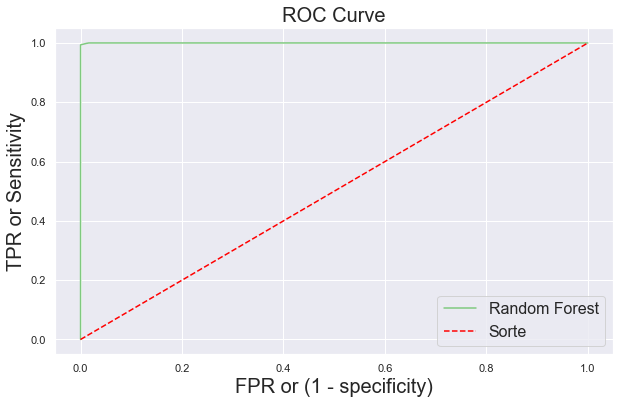

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3563
           1       1.00      0.99      1.00      3606

    accuracy                           1.00      7169
   macro avg       1.00      1.00      1.00      7169
weighted avg       1.00      1.00      1.00      7169

AUC: 0.9966722129783694


In [37]:
clf_rf.fit(treino_x[features_selected[:-1]], treino_y)
predict_rf = clf_rf.predict(teste_x[features_selected[:-1]])

y_score_rf = clf_rf.predict_proba(teste_x[features_selected[:-1]])[:,1]
fpr, tpr, treshold = roc_curve(teste_y, y_score_rf)

plota_roc_curve(fpr, tpr, predict_rf, "Random Forest")

Temos aqui algumas métricas importantes.

O valor de métrica AUC (area under the curve) está muito próximo de 1, máximo valor possível. Quanto mais próximo de 1, melhor o poder de predição do nosso modelo.

Esta acurácia está muito boa, principalmente se compararmos a curva em verde referente ao nosso modelo (Rando Forest) com a curva tracejada em vermelho referente a uma classificação feita com base na sorte "chute".

Logo, a **Random Forest** se ajustou muito bem aos dados de teste.

Vamos analisar a matriz de confusão deste modelo.

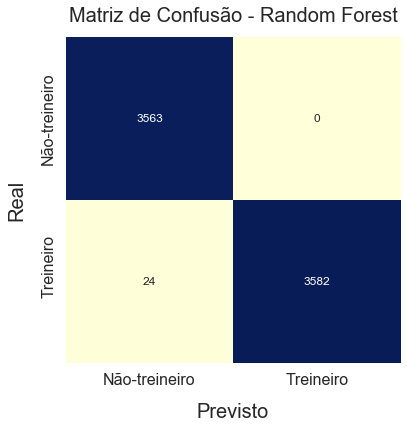

In [38]:
plot_matriz_confusao(teste_y, predict_rf, "Random Forest")

Nosso modelo não cometeu nenhum erro do tipo 1 (**Falsos positivos**). Isto quer dizer que o modelo não classificou nenhum candidato como treineiro quando na verdade o mesmo não era.

Porém, tivemos **31 falsos negativos** erro do tipo 2. Ou seja, nosso modelo classificou 23 candidatos como sendo pertencentes à classe não-treineiro, quando na verdade os mesmo eram treineiros.

Vamos agora avaliar outros modelos para fazermos nossa escolha.
### SGDClassifier - Stochastic Gradient Descent

In [39]:
clf_SGD = SGDClassifier()
clf_SGD.fit(treino_x[features_selected], treino_y)
predict_SGD = clf_SGD.predict(teste_x[features_selected])

y_score = clf_SGD.decision_function(teste_x[features_selected])
fpr, tpr, _ = roc_curve(teste_y, y_score)

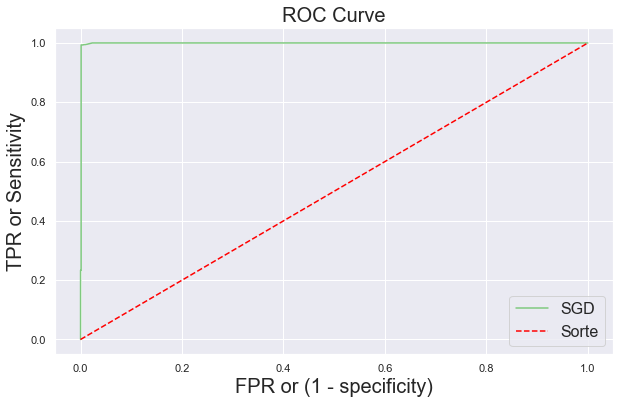

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3563
           1       1.00      0.99      1.00      3606

    accuracy                           1.00      7169
   macro avg       1.00      1.00      1.00      7169
weighted avg       1.00      1.00      1.00      7169

AUC: 0.9956898947072496


In [40]:
plota_roc_curve(fpr, tpr, predict_SGD, "SGD")

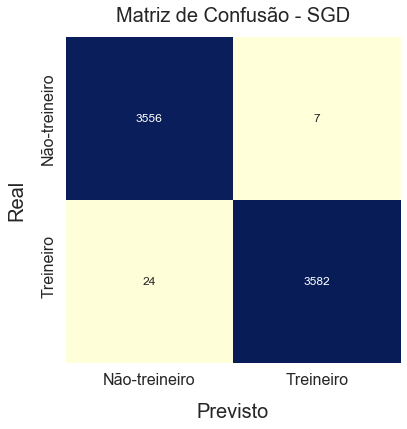

In [50]:
plot_matriz_confusao(teste_y, predict_SGD, "SGD")

### Logistic Regression

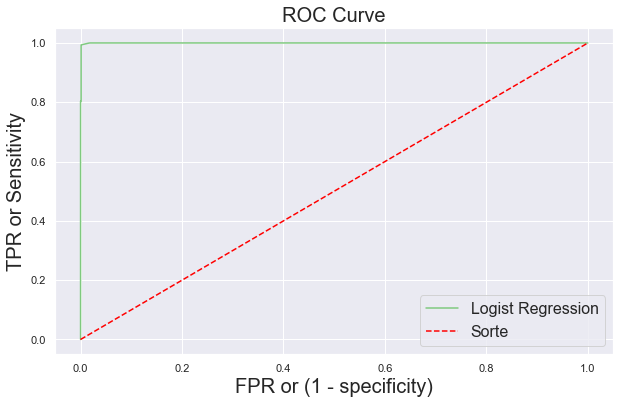

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3563
           1       1.00      0.99      1.00      3606

    accuracy                           1.00      7169
   macro avg       1.00      1.00      1.00      7169
weighted avg       1.00      1.00      1.00      7169

AUC: 0.9958302258888381


In [42]:
clf_LR = LogisticRegression()
clf_LR.fit(treino_x[features_selected], treino_y)
predict_LR = clf_LR.predict(teste_x[features_selected])

y_score_LR = clf_LR.predict_proba(teste_x[features_selected])[:,1]
fpr, tpr, threshold = roc_curve(teste_y, y_score_LR)
plota_roc_curve(fpr, tpr, predict_LR, "Logist Regression")

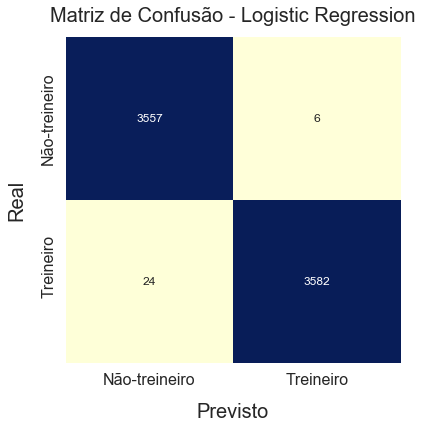

In [43]:
plot_matriz_confusao(teste_y, predict_LR, "Logistic Regression")

### KNeighborsClassifier

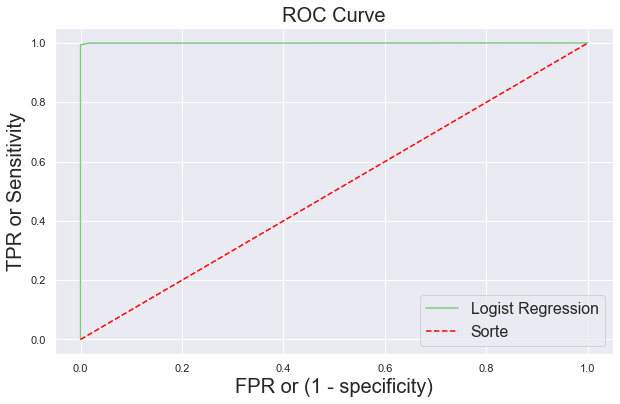

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3563
           1       1.00      0.99      1.00      3606

    accuracy                           1.00      7169
   macro avg       1.00      1.00      1.00      7169
weighted avg       1.00      1.00      1.00      7169

AUC: 0.9966722129783694


In [44]:
clf_KNN = KNeighborsClassifier(7)
clf_KNN.fit(treino_x[features_selected], treino_y)
predict_KNN = clf_KNN.predict(teste_x[features_selected])

y_score_KNN = clf_KNN.predict_proba(teste_x[features_selected])[:,1]
fpr, tpr, threshold = roc_curve(teste_y, y_score_KNN)
plota_roc_curve(fpr, tpr, predict_KNN, "Logist Regression")

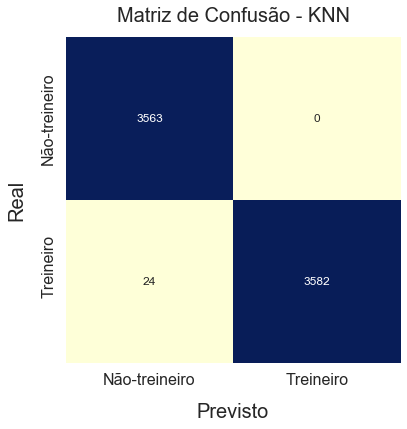

In [45]:
plot_matriz_confusao(teste_y, predict_KNN, "KNN")

### SVC - Support Vector Classification

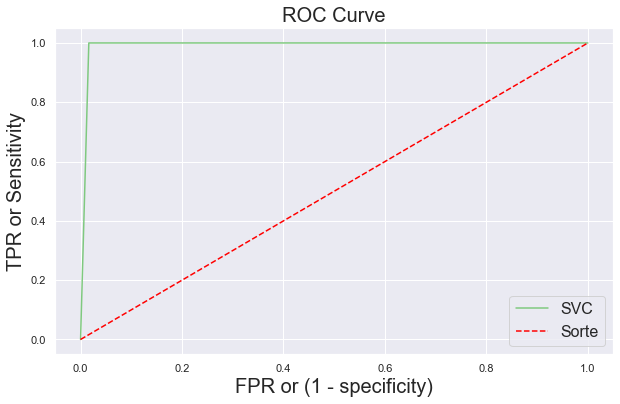

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3563
           1       0.98      1.00      0.99      3606

    accuracy                           0.99      7169
   macro avg       0.99      0.99      0.99      7169
weighted avg       0.99      0.99      0.99      7169

AUC: 0.9918607914678641


In [46]:
scaler = StandardScaler()
treino_x_standard = scaler.fit_transform(treino_x[features_selected])
teste_x_standard = scaler.transform(teste_x[features_selected])

clf_svm = SVC()
clf_svm.fit(treino_x_standard, treino_y)
predict_svm = clf_svm.predict(teste_x_standard)

y_score_svm = clf_svm.decision_function(teste_x_standard)
fpr, tpr, threshold = roc_curve(teste_y, predict_svm)
plota_roc_curve(fpr, tpr, predict_svm, "SVC")

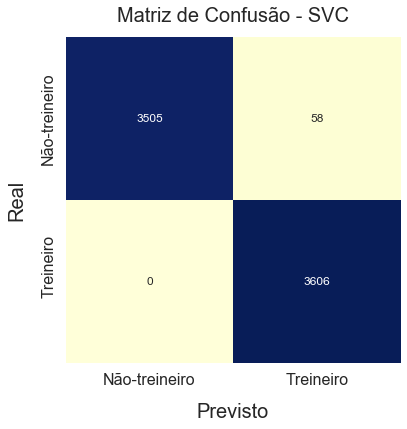

In [47]:
plot_matriz_confusao(teste_y, predict_svm, "SVC")

### GradientBoostingClassifier

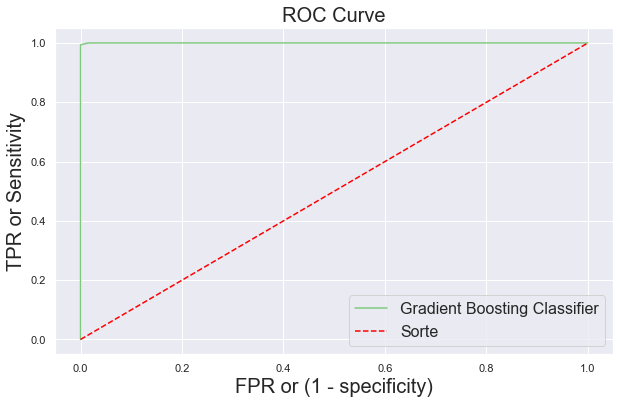

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3563
           1       1.00      0.99      1.00      3606

    accuracy                           1.00      7169
   macro avg       1.00      1.00      1.00      7169
weighted avg       1.00      1.00      1.00      7169

AUC: 0.9966722129783694


In [48]:
clf_GBC = GradientBoostingClassifier()
clf_GBC.fit(treino_x[features_selected], treino_y)
predict_GBC = clf_GBC.predict(teste_x[features_selected])

y_score_GBC = clf_GBC.predict_proba(teste_x[features_selected])[:,1]
fpr, tpr, threshold = roc_curve(teste_y, y_score_GBC)
plota_roc_curve(fpr, tpr, predict_GBC, "Gradient Boosting Classifier")

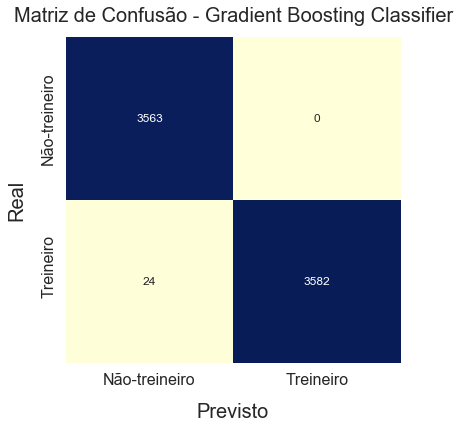

In [49]:
plot_matriz_confusao(teste_y, predict_GBC, "Gradient Boosting Classifier")

Este modelo obteve resultados idênticos ao da Random Forest.
### Qual Modelo Escolher?
Analisando os resultados dos testes de todos os modelos, concluimos que uma vez que os dados estejam ajustados a diferença de performance dos modelos foi praticamente nula.

O modelo a ser utilizado foi o **Random Forest** por ser um modelo Robusto, geralmente eficiente neste tipo de problema de classifação e também pelo fato de que neste modelo as variáveis numéricas não precisam ser pré-processadas (normalizar ou padronizar, nesse caso).
## Submetendo os Resultados na Plataforma da Codenation

In [51]:
clf_RF = RandomForestClassifier(random_state=42)
clf_RF.fit(treino_x[features_selected], treino_y)
predict = clf_RF.predict(x_test_encoded[features_selected])

predict = pd.Series(predict, name="IN_TREINEIRO")
df = pd.read_csv("test.csv")[["NU_INSCRICAO"]]
answer = pd.concat([df, predict], axis=1)
answer.to_csv("answer.csv", index=False)
answer

,NU_INSCRICAO,IN_TREINEIRO
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0
1,177f281c68fa032aedbd842a745da68490926cd2,0
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,1
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0
5,3f28749fb79fb059caf5aed79625a5addfd7a91a,0
6,bb2a0edddf3c59181a1496390aaaee7f32624d9d,1
7,cc7cab347fe5455aae983f3701ca40f84dc01949,0
8,95e9338f1da02f7bfa0e3194130afdccc0fb5457,1
9,155f84f2ee5b34e658f2adcc70f2ec83e37040cb,0


## Resultado
Após enviar nossas predições para a plaforma tivemos o seguinte resultado reportado pela plataforma:

**Score**: 99.7374 %

> Isto quer dizer que nosso modelo conseguiu acertar 99.7374 % das suas predições!!! **Nada mal, para algumas árvores**.

Agora que já alcançamos um excelente resultado, vamos tentar manter o score, porém, reduzindo ainda mais o número de features necessárias para o modelo.

**Será que isso é possível?**

Vamos investigar...

## Reduzindo ainda mais as Features

In [52]:
selection_features

,features,importancia
0,TP_ST_CONCLUSAO_3,0.213083
1,NU_IDADE,0.199957
2,TP_ANO_CONCLUIU_0,0.081902
3,TP_ESCOLA_1,0.080091
4,TP_ST_CONCLUSAO_1,0.073851
5,TP_ST_CONCLUSAO_2,0.059187
6,TP_ESCOLA_2,0.054376
7,Q026_B,0.034353
8,Q026_C,0.026549
9,Q026_A,0.016206


Esse foi o resultado que obtivemos lá na etapa de feature selection.

Esta tabela contém as features com maior importância para a predição do modelo.

Analisando a tabela com atenção, notamos que as duas primeiras features TP_ST_CONCLUSAO_3 e NU_IDADE, possuem um importância muito superior as demais para a predição do nosso modelo.

Vamos então rodar novamente o nosso modelo, porém, agora somente com estas duas features.

Valhe lembrar aqui, como estão os nosso dados de treino.

In [53]:
treino_x[features_selected]

,TP_ST_CONCLUSAO_3,NU_IDADE,TP_ANO_CONCLUIU_0,TP_ESCOLA_1,TP_ST_CONCLUSAO_1,TP_ST_CONCLUSAO_2,TP_ESCOLA_2,Q026_B,Q026_C,Q026_A,TP_ANO_CONCLUIU_1,Q001_B,TP_ST_CONCLUSAO_4,TP_ANO_CONCLUIU_2
1514,1,16,1,1,0,0,0,0,0,1,0,0,0,0
18379,1,16,1,1,0,0,0,0,0,1,0,0,0,0
9742,1,15,1,1,0,0,0,0,0,1,0,0,0,0
3693,1,17,1,1,0,0,0,0,0,1,0,0,0,0
8704,0,20,1,0,0,1,1,0,0,1,0,0,0,0
5304,0,17,1,0,0,1,1,0,0,1,0,0,0,0
11852,0,39,0,1,1,0,0,0,1,0,0,0,0,0
5321,1,17,1,1,0,0,0,0,0,1,0,0,0,0
10030,0,18,1,0,0,1,1,0,0,1,0,0,0,0
9578,1,16,1,1,0,0,0,0,0,1,0,0,0,0


Estamos trabalhando com **14 features** até aqui.

Vamos reduzir para **apenas as duas**. Usaremos as duas features mais importantes para o nososo modelo: TP_ST_CONCLUSAO_3 e NU_IDADE.

In [54]:
features_selected_2 = ["TP_ST_CONCLUSAO_3", "NU_IDADE"]

clf_RF.fit(treino_x[features_selected_2], treino_y)
predict = clf_RF.predict(x_test_encoded[features_selected_2])

predict = pd.Series(predict, name="IN_TREINEIRO")
df = pd.read_csv("test.csv")[["NU_INSCRICAO"]]
answer = pd.concat([df, predict], axis=1)
answer.to_csv("answer.csv", index=False)
answer

,NU_INSCRICAO,IN_TREINEIRO
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0
1,177f281c68fa032aedbd842a745da68490926cd2,0
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,1
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0
5,3f28749fb79fb059caf5aed79625a5addfd7a91a,0
6,bb2a0edddf3c59181a1496390aaaee7f32624d9d,1
7,cc7cab347fe5455aae983f3701ca40f84dc01949,0
8,95e9338f1da02f7bfa0e3194130afdccc0fb5457,1
9,155f84f2ee5b34e658f2adcc70f2ec83e37040cb,0


### Resultado
Após enviar nossas predições para a plaforma tivemos o seguinte resultado reportado pela plataforma:

**Score**: 99.7374 %

> **Este resultado é espetacular!!!** Conseguimos manter o Score elevado, ao ponto que reduzimos para apenas 2 as features necessárias para nosso modelo realizar tal feito!

## Conclusão
Percebemos ao longo de todo o processo que, uma vez que tratamos e selecionamos os dados, os modelos que testamos apresentaram performances muito semelhantes. Optamos por seguir com a Random Forest, embora ou outros modelos testados tenham apresentado potencial igualmente capaz para resolver o probelma.

Obtivemos um Score de 99.7374 % utilizando a **Random Forest** e as **14 features** que selecionamos como sendo as mais importantes para a predição na etapa de feature selection.

Em seguida, tentamos reduzir ainda mais as features disponíveis sem comprometer o score. E conseguimos!

Após observarmos que as features mais importantes para predição são TP_ST_CONCLUSAO_3 e NU_IDADE, e ambas possuem uma importãncia muito superior as demais. Utilizamos apenas estas para alimentar nosso modelo.

E o **resultado foi surpreendente**! Conseguimos manter o Score elevado **99.7374 %**, ao ponto que reduzimos para apenas 2 as features necessárias para nosso modelo realizar tal feito!

Portanto, após todos os processos de análise descritiva, pré-processamento dos dados, modelagem, treino e avaliação de modelos conseguimos reduzir de **183 variáveis** para **apenas 2** com o score final de 99.7374 %.

## Referências
- [Classification: Basic Concepts, Decision Trees, and Model Evaluation](https://www-users.cs.umn.edu/~kumar001/dmbook/ch4.pdf)
- [Having an Imbalanced Dataset? Here Is How You Can Fix It](https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb)
- [Foundations of Imbalanced Learning](https://pdfs.semanticscholar.org/1678/7e213ed0a5c0cf9baabdb45f9df631248a91.pdf)
- [Data Mining for Imbalanced Datasets: An Overview](https://www3.nd.edu/~dial/publications/chawla2005data.pdf)
- [Classification: Basci Concepts, Decision Trees, and Model Evaluation](https://www-users.cs.umn.edu/~kumar001/dmbook/ch4.pdf)
- [Documentação do módulo SMOTE](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html)